# Word to vec Embedding Models

The word2vec algorithm finds much more efficient representations by finding vectors that represent the words. These vectors also contain semantic information about the words. Words that show up in similar contexts, such as "black", "white", and "red" will have vectors near each other. There are two architectures for implementing word2vec, CBOW (Continuous Bag-Of-Words) and Skip-gram.

--------

In [12]:
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)

In [13]:
%matplotlib inline
import pandas as pd
import numpy as np
import gensim
import matplotlib.pyplot as plt
import scikitplot.plotters as skplt
import nltk
from collections import Counter
import time
import tensorflow as tf
from matplotlib.patches import Patch
from matplotlib.markers import MarkerStyle
import seaborn as sns
from sklearn.manifold import TSNE
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import random

### Get the data

In [14]:
train = pd.read_csv('data.csv')

### Visualizing Word to Vec Imbedding (skip gram model)

In [15]:
from  w2vec_helper import preprocess,token_lookup,create_lookup_tables

Preparing all text words

In [16]:
text = train['Text']
all_txt = ''
for k in range(len(text)):
           txt = text.iloc[k]
           all_txt = all_txt+txt
            
            
words = preprocess(all_txt)
print("Total words: {}".format(len(words)))
print("Unique words: {}".format(len(set(words))))
print(words[:30])

Total words: 75275
Unique words: 2300
['the', 'minimum', 'description', 'length', 'principle', 'for', 'sequence', 'in', 'a', 'proper', 'learning', 'setup', 'is', 'studied', 'if', 'the', 'underlying', 'model', 'class', 'is', 'discrete', '<COMMA>', 'then', 'the', 'total', 'expected', 'square', 'loss', 'is', 'a']


Preparing lookup table.

In [17]:
vocab_to_int, int_to_vocab = create_lookup_tables(words)
int_words = [vocab_to_int[word] for word in words]

#### Subsampling

Words that show up often such as "the", "of", and "for" don't provide much context to the nearby words. If we discard some of them, we can remove some of the noise from our data and in return get faster training and better representations. This process is called subsampling 

In [18]:
from collections import Counter

threshold = 1e-5
word_counts = Counter(int_words)
total_count = len(int_words)
freqs = {word: count/total_count for word, count in word_counts.items()}
p_drop = {word: 1 - np.sqrt(threshold/freqs[word]) for word in word_counts}
train_words = [word for word in int_words if random.random() < (1 - p_drop[word])]

#### Prepare batches and targets

With the skip-gram architecture, for each word in the text, we want to grab all the words in a window around that word, with size $C$.
From Mikolov et al.
"Since the more distant words are usually less related to the current word than those close to it, we give less weight to the distant words by sampling less from those words in our training examples... If we choose $C = 5$, for each training word we will select randomly a number $R$ in range $<1; C>$, and then use $R$ words from history and $R$ words from the future of the current word as correct labels."

In [19]:
def get_target(words, idx, window_size=5):
    ''' Get a list of words in a window around an index. '''
    
    R = np.random.randint(1, window_size+1)
    start = idx - R if (idx - R) > 0 else 0
    stop = idx + R
    target_words = set(words[start:idx] + words[idx+1:stop+1])
    
    return list(target_words)

In [20]:
def get_batches(words, batch_size, window_size=5):
    ''' Create a generator of word batches as a tuple (inputs, targets) '''
    
    n_batches = len(words)//batch_size
    
    # only full batches
    words = words[:n_batches*batch_size]
    
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx+batch_size]
        for ii in range(len(batch)):
            batch_x = batch[ii]
            batch_y = get_target(batch, ii, window_size)
            y.extend(batch_y)
            x.extend([batch_x]*len(batch_y))
        yield x, y

#### Embedding

Tensorflow provides a convenient function ***tf.nn.embedding_lookup*** that does this lookup for us. You pass in the ```embedding matrix``` and a tensor of integers, then it returns rows in the matrix corresponding to those integers. Below, set the number of embedding features you'll use (200 is a good start), create the embedding matrix variable, and use ```tf.nn.embedding_lookup``` to get the embedding tensors. For the embedding matrix, I suggest you initialize it with a uniform random numbers between -1 and 1 using ```tf.random_uniform```.

In [21]:
train_graph = tf.Graph()
with train_graph.as_default():
    inputs = tf.placeholder(tf.int32, [None], name='inputs')
    labels = tf.placeholder(tf.int32, [None, None], name='labels')

In [22]:
n_vocab = len(int_to_vocab)
n_embedding = 200 # Number of embedding features 
with train_graph.as_default():
    embedding = tf.Variable(tf.random_uniform((n_vocab, n_embedding), -1, 1))
    embed = tf.nn.embedding_lookup(embedding, inputs)

#### Negative Sampling

For every example we give the network, we train it using the output from the softmax layer. That means for each input, we're making very small changes to millions of weights even though we only have one true example. This makes training the network very inefficient. We can approximate the loss from the softmax layer by only updating a small subset of all the weights at once. We'll update the weights for the correct label, but only a small number of incorrect labels. This is called "negative sampling". Tensorflow has a convenient function to do this, ```tf.nn.sampled_softmax_loss```.

In [23]:
# Number of negative labels to sample
n_sampled = 100
with train_graph.as_default():
    softmax_w = tf.Variable(tf.truncated_normal((n_vocab, n_embedding), stddev=0.1))
    softmax_b = tf.Variable(tf.zeros(n_vocab))
    
    # Calculate the loss using negative sampling
    loss = tf.nn.sampled_softmax_loss(softmax_w, softmax_b, 
                                      labels, embed,
                                      n_sampled, n_vocab)
    
    cost = tf.reduce_mean(loss)
    optimizer = tf.train.AdamOptimizer().minimize(cost)

#### Validation

In [24]:
with train_graph.as_default():
    ## From Thushan Ganegedara's implementation
    valid_size = 16 # Random set of words to evaluate similarity on.
    valid_window = 100
    # pick 8 samples from (0,100) and (1000,1100) each ranges. lower id implies more frequent 
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples, 
                               random.sample(range(1000,1000+valid_window), valid_size//2))

    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embedding), 1, keep_dims=True))
    normalized_embedding = embedding / norm

In [25]:
# If the checkpoints directory doesn't exist:
!mkdir checkpoints

mkdir: checkpoints: File exists


#### Train embedding

In [26]:
epochs = 10
batch_size = 1000
window_size = 10

with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    iteration = 1
    loss = 0
    sess.run(tf.global_variables_initializer())

    for e in range(1, epochs+1):
        batches = get_batches(train_words, batch_size, window_size)
        start = time.time()
        for x, y in batches:
            
            feed = {inputs: x,
                    labels: np.array(y)[:, None]}
            train_loss, _ = sess.run([cost, optimizer], feed_dict=feed)
            
            loss += train_loss
            
            if iteration % 100 == 0: 
                end = time.time()
                print("Epoch {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Avg. Training loss: {:.4f}".format(loss/100),
                      "{:.4f} sec/batch".format((end-start)/100))
                loss = 0
                start = time.time()
            
            if iteration % 1000 == 0:
                # note that this is expensive (~20% slowdown if computed every 500 steps)
                sim = similarity.eval()
                for i in range(valid_size):
                    valid_word = int_to_vocab[valid_examples[i]]
                    top_k = 8 # number of nearest neighbors
                    nearest = (-sim[i, :]).argsort()[1:top_k+1]
                    log = 'Nearest to %s:' % valid_word
                    for k in range(top_k):
                        close_word = int_to_vocab[nearest[k]]
                        log = '%s %s,' % (log, close_word)
                    print(log)
            
            iteration += 1
    save_path = saver.save(sess, "checkpoints/text8.ckpt")
    embed_mat = sess.run(normalized_embedding)

In [27]:
with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    embed_mat = sess.run(embedding)

#### Visualization of word vectors

In [28]:
viz_words = 500
tsne = TSNE()
embed_tsne = tsne.fit_transform(embed_mat[:viz_words, :])

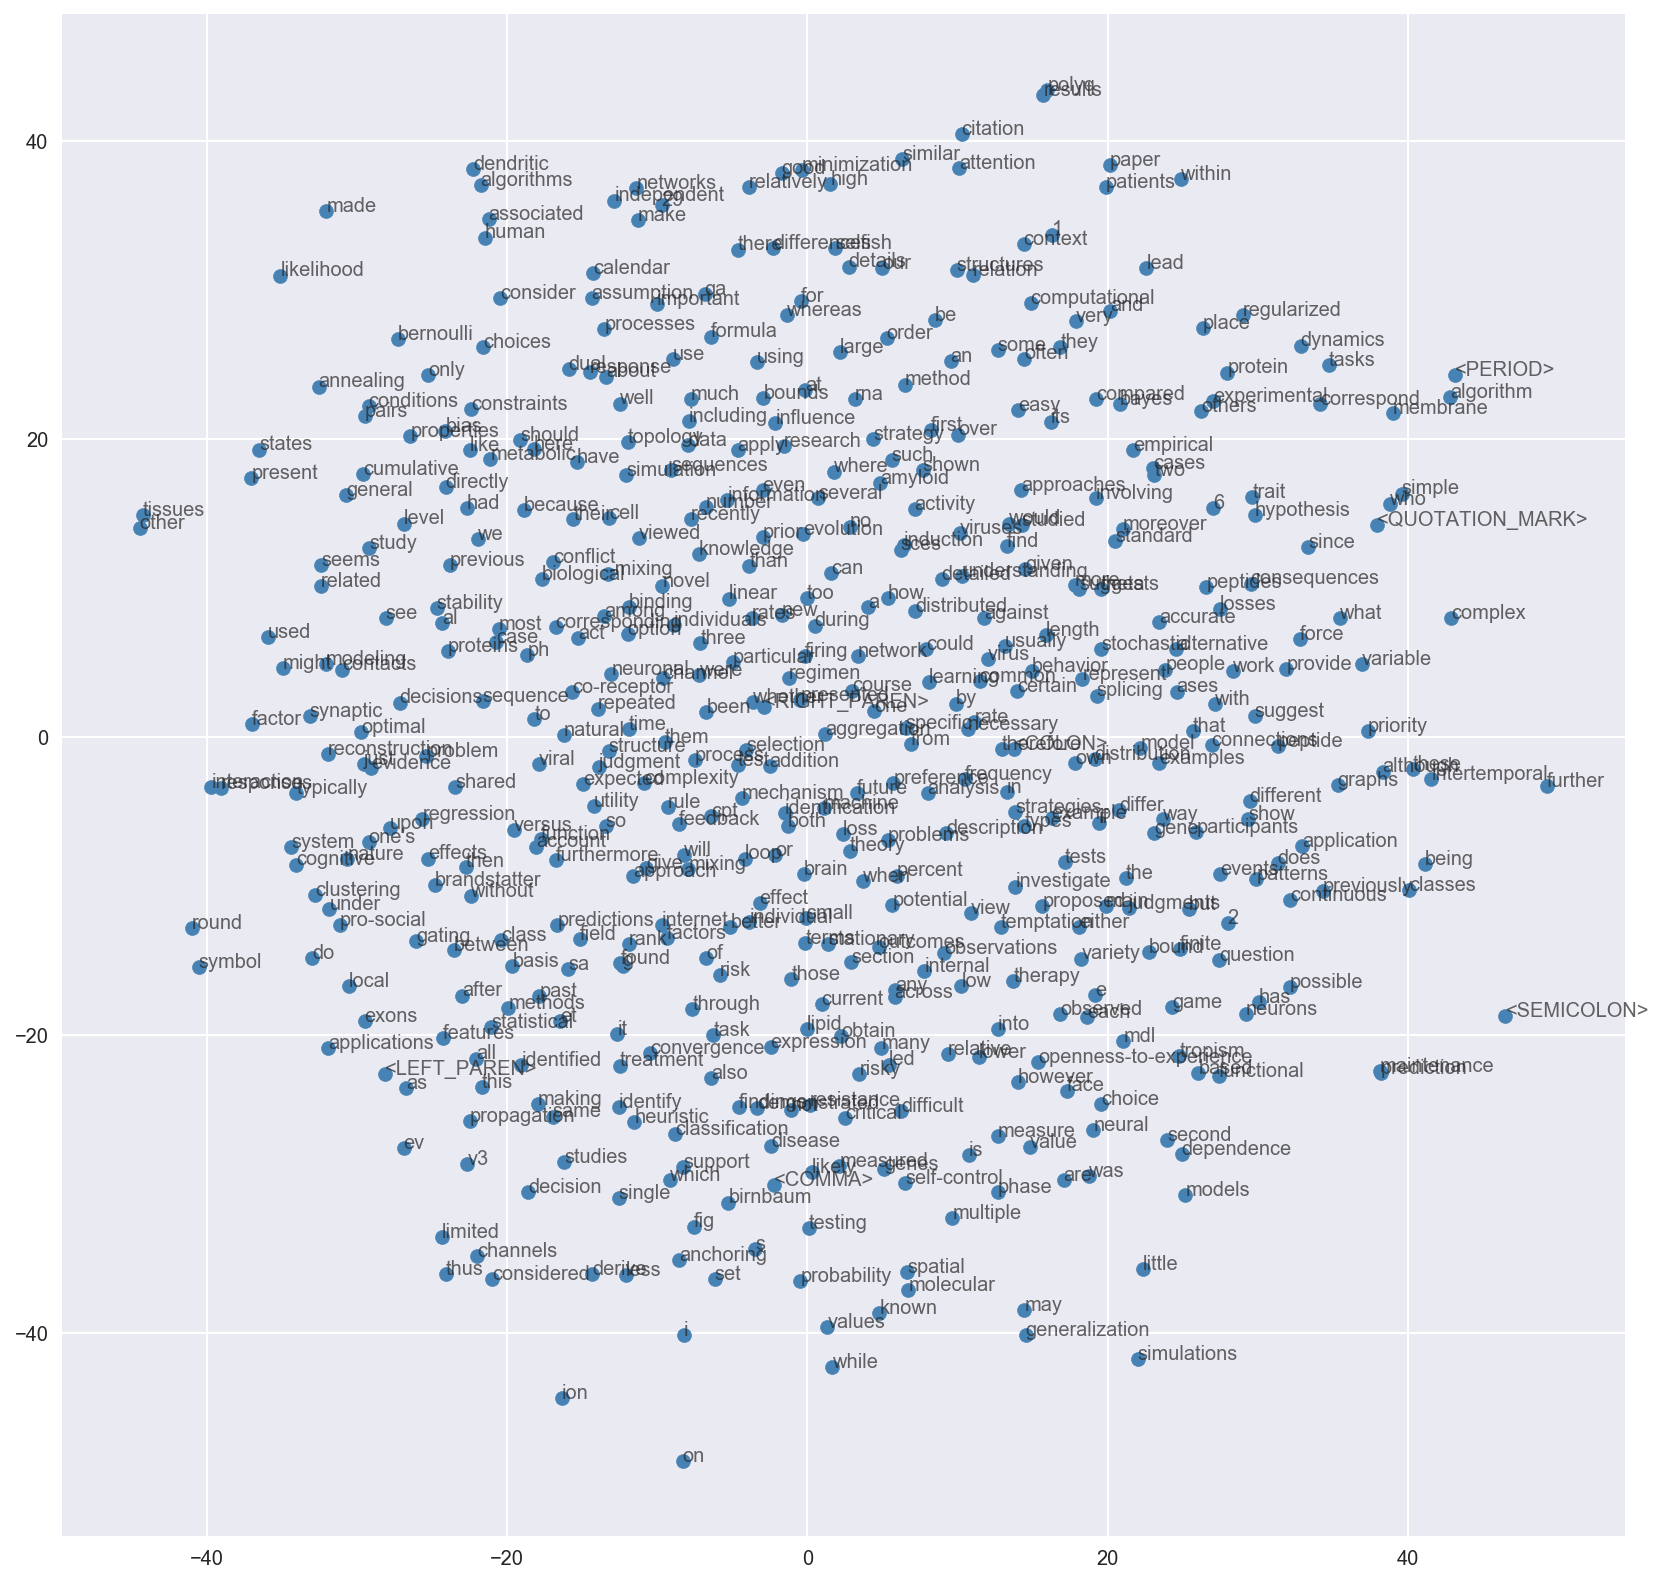

In [29]:
fig, ax = plt.subplots(figsize=(14, 14))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)

In [30]:
print(embed_mat)

[[-0.82701319  0.92688292 -0.70246989 ...,  0.201921    0.45097616
  -0.5026148 ]
 [-0.30865261  0.19972552  0.17675157 ..., -0.87805897 -0.61002332
  -0.00186399]
 [ 0.05564037  0.12178899 -0.38852248 ...,  0.81141388  0.90691859
  -0.12877525]
 ..., 
 [ 0.05303505 -0.55036676  0.2523399  ..., -0.82980299  0.94556236
   0.41186488]
 [-0.29503024  0.18808904 -0.91025549 ..., -0.28788242 -0.83409762
  -0.66979265]
 [-0.36286241 -0.14922051 -0.01226528 ..., -0.37042949 -0.56742328
   0.91571546]]


--------

### 6.2 RNN with LSTM and word2vec embedding

------

In [31]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.optimizers import Adam

In [32]:
# Use the Keras tokenizer
num_words = 2000
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(train['Text'].values)

In [33]:
# Pad the data 
X = tokenizer.texts_to_sequences(train['Text'].values)
X = pad_sequences(X, maxlen=2000)

In [34]:
# Build out our simple LSTM
embed_dim = 32
lstm_out = 20

# Model saving callback
ckpt_callback = ModelCheckpoint('keras_model', 
                                 monitor='val_loss', 
                                 verbose=1, 
                                 save_best_only=True, 
                                 mode='auto')

model = Sequential()

model.add(Embedding(num_words, embed_dim, input_length = X.shape[1]))

model.add(LSTM(lstm_out, return_sequences=True, input_shape=(embed_dim, 1) ))

model.add(LSTM(10, recurrent_dropout=0.2, dropout=0.2))

model.add(Dense(5,activation='softmax'))

model.compile(loss = 'categorical_crossentropy',
              optimizer='adam',
              metrics = ['acc'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2000, 32)          64000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 2000, 20)          4240      
_________________________________________________________________
lstm_2 (LSTM)                (None, 10)                1240      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 55        
Total params: 69,535
Trainable params: 69,535
Non-trainable params: 0
_________________________________________________________________
None


In [35]:
from sklearn.model_selection import train_test_split
Y = pd.get_dummies(train['Label']).values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    test_size = 0.2,
                                                    random_state = 42,
                                                    stratify=Y)

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(2493, 2000) (2493, 5)
(624, 2000) (624, 5)


In [33]:
batch_size = 156
history = model.fit(X_train,
          Y_train, 
          epochs=40, 
          batch_size=batch_size,
          validation_split=0.2,
          callbacks=[ckpt_callback])

Train on 1994 samples, validate on 499 samples
Epoch 1/40
1994/1994 [==============================] - 151s - loss: 1.5501 - acc: 0.5587 - val_loss: 1.4599 - val_acc: 0.5912
Epoch 2/40
1994/1994 [==============================] - 149s - loss: 1.3673 - acc: 0.5792 - val_loss: 1.2429 - val_acc: 0.5912
Epoch 3/40
1994/1994 [==============================] - 151s - loss: 1.2078 - acc: 0.5792 - val_loss: 1.1092 - val_acc: 0.5912
Epoch 4/40
1994/1994 [==============================] - 149s - loss: 1.1299 - acc: 0.5792 - val_loss: 1.0634 - val_acc: 0.5912
Epoch 5/40
1994/1994 [==============================] - 147s - loss: 1.1081 - acc: 0.5792 - val_loss: 1.0471 - val_acc: 0.5912
Epoch 6/40
1994/1994 [==============================] - 147s - loss: 1.1036 - acc: 0.5792 - val_loss: 1.0423 - val_acc: 0.5912
Epoch 7/40
1994/1994 [==============================] - 156s - loss: 1.1029 - acc: 0.5792 - val_loss: 1.0407 - val_acc: 0.5912
Epoch 8/40
1994/1994 [==============================] - 150s - l

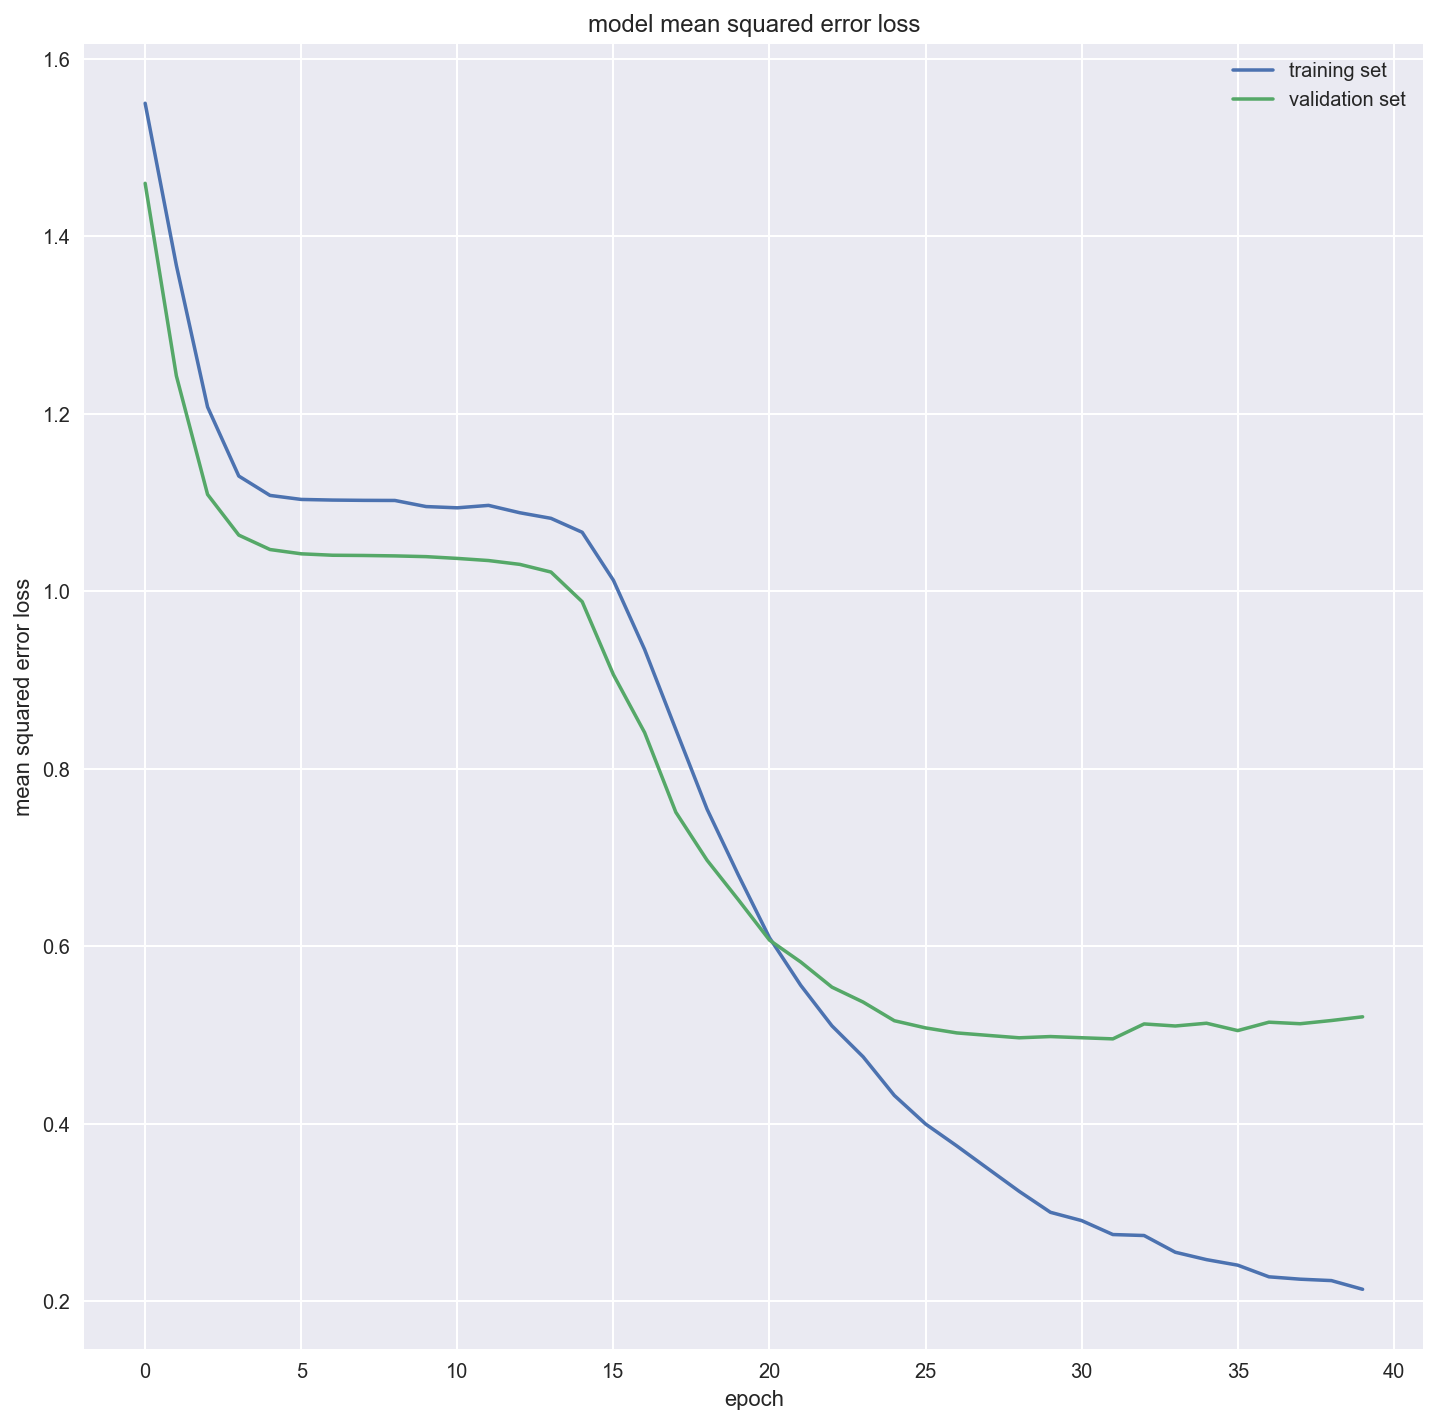

In [34]:
plt.figure(figsize=(12,12))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

Log loss: 0.5781910423344622
Accuracy: 0.8333333333333334


/Users/dibakarsigdel/anaconda/envs/carnd-term1/lib/python3.5/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)


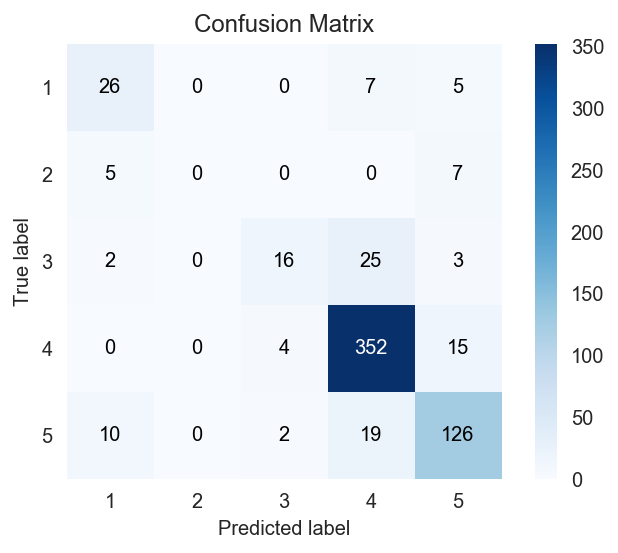

In [35]:
model = load_model('keras_model')
probas = model.predict(X_test)
pred_indices = np.argmax(probas, axis=1)
classes = np.array(range(1, 10))
preds = classes[pred_indices]
print('Log loss: {}'.format(log_loss(classes[np.argmax(Y_test, axis=1)], probas)))
print('Accuracy: {}'.format(accuracy_score(classes[np.argmax(Y_test, axis=1)], preds)))
skplt.plot_confusion_matrix(classes[np.argmax(Y_test, axis=1)], preds)

-------